# [TUM - miniprojekt] Przebieg procesu uczenia dla sieci przy użyciu różnych algorytmów optymalizacji
## Autorzy: Agnieszka Klimek (145302), Anna Prałat (145395)

In [1]:
# %pip install torch torchvision tqdm pandas matplotlib seaborn

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [3]:
DATASET_PATH: str = "./datasets"
MODEL_PATH: str = "./models"
RESULT_PATH: str = "./results"

BATCH_SIZE: int = 4

In [4]:
def get_dataset(dataset, batch_size: int = BATCH_SIZE) -> tuple:
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    train_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=True)
    valid_set = dataset(root=DATASET_PATH, download=True, transform=transform, train=False)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader

In [5]:
datasets = {
    "FashionMNIST": torchvision.datasets.FashionMNIST,
    "MNIST": torchvision.datasets.MNIST,
}

In [6]:
device = torch.device(
    "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
)
print(device)


class CNNClassifier(nn.Module):
    def __init__(self, number_of_channels: int = 1, number_of_classes: int = 10) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(number_of_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, number_of_classes)

    def forward(self, x) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

mps


In [7]:
optimizers = {
    "SGD": optim.SGD,
    "AdaGrad": optim.Adagrad,
    "Adam": optim.Adam,
    "AdamW": optim.AdamW,
    "RMSprop": optim.RMSprop,
}

In [8]:
loss_fn = nn.CrossEntropyLoss()


def train_epoch(model, train_loader, optimizer, lr: float = 1e-3) -> float:
    model.train()
    optimizer = optimizer(model.parameters(), lr=lr)

    running_loss = 0.0
    # avg_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # if i % 1000 == 999:
        #     avg_loss = running_loss / 1000
        #     print(f"[{i + 1:5d}] loss: {avg_loss:.3f}")
        #     running_loss = 0.0

    avg_loss = running_loss / (i + 1)
    return avg_loss


def valid_epoch(model, valid_loader) -> float:
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(tqdm(valid_loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

    avg_loss = running_loss / (i + 1)
    return avg_loss

In [9]:
NUMBER_OF_EPOCHS: int = 100

In [10]:
for dataset_name, dataset in datasets.items():
    print(f"DATASET: {dataset_name}")
    train_loader, valid_loader = get_dataset(dataset)

    for optimizer_name, optimizer in optimizers.items():
        print(f"OPTIMIZER: {optimizer_name}")

        model = CNNClassifier()
        model.to(device)

        best_vloss = np.inf

        results: list = []

        for epoch_number in range(NUMBER_OF_EPOCHS):
            print(f"EPOCH: {epoch_number + 1} / {NUMBER_OF_EPOCHS}")

            avg_loss = train_epoch(model, train_loader, optimizer)

            avg_vloss = valid_epoch(model, valid_loader)

            results.append(
                {
                    "epoch": epoch_number,
                    "train_loss": avg_loss,
                    "valid_loss": avg_vloss,
                }
            )

            print(f"Train Loss: {avg_loss:.3f}, Valid Loss: {avg_vloss:.3f}")

            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                if not os.path.exists(MODEL_PATH):
                    os.makedirs(MODEL_PATH)
                torch.save(
                    model.state_dict(), f"{MODEL_PATH}/{dataset_name}_{optimizer_name}_model.pth"
                )
            else:
                print(
                    f"Early stopping (no improvement in validation loss in epoch {epoch_number + 1})"
                )
                break

        results_df = pd.DataFrame(results)
        if not os.path.exists(RESULT_PATH):
            os.makedirs(RESULT_PATH)
        results_df.to_csv(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv", index=False)

DATASET: FashionMNIST


100%|██████████| 26421880/26421880 [00:03<00:00, 7844745.16it/s] 


Extracting ./datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 1108131.25it/s]


Extracting ./datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 10984951.43it/s]


Extracting ./datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5614216.59it/s]


Extracting ./datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw

OPTIMIZER: SGD
EPOCH: 1 / 100


100%|██████████| 2500/2500 [00:03<00:00, 769.74it/s]


Train Loss: 1.608, Valid Loss: 0.862
EPOCH: 2 / 100


100%|██████████| 2500/2500 [00:02<00:00, 873.28it/s]


Train Loss: 0.731, Valid Loss: 0.656
EPOCH: 3 / 100


100%|██████████| 2500/2500 [00:02<00:00, 873.05it/s]


Train Loss: 0.583, Valid Loss: 0.545
EPOCH: 4 / 100


100%|██████████| 2500/2500 [00:02<00:00, 865.68it/s]


Train Loss: 0.500, Valid Loss: 0.485
EPOCH: 5 / 100


100%|██████████| 2500/2500 [00:02<00:00, 873.55it/s]


Train Loss: 0.444, Valid Loss: 0.433
EPOCH: 6 / 100


100%|██████████| 2500/2500 [00:02<00:00, 863.43it/s]


Train Loss: 0.401, Valid Loss: 0.403
EPOCH: 7 / 100


100%|██████████| 2500/2500 [00:02<00:00, 877.24it/s]


Train Loss: 0.372, Valid Loss: 0.381
EPOCH: 8 / 100


100%|██████████| 2500/2500 [00:02<00:00, 866.66it/s]


Train Loss: 0.351, Valid Loss: 0.369
EPOCH: 9 / 100


100%|██████████| 2500/2500 [00:02<00:00, 867.50it/s]


Train Loss: 0.337, Valid Loss: 0.391
Early stopping (no improvement in validation loss in epoch 9)
OPTIMIZER: AdaGrad
EPOCH: 1 / 100


100%|██████████| 2500/2500 [00:02<00:00, 847.66it/s]


Train Loss: 0.846, Valid Loss: 0.754
EPOCH: 2 / 100


100%|██████████| 2500/2500 [00:02<00:00, 858.31it/s]


Train Loss: 0.680, Valid Loss: 0.676
EPOCH: 3 / 100


100%|██████████| 2500/2500 [00:03<00:00, 791.08it/s]


Train Loss: 0.621, Valid Loss: 0.626
EPOCH: 4 / 100


100%|██████████| 2500/2500 [00:02<00:00, 859.13it/s]


Train Loss: 0.581, Valid Loss: 0.590
EPOCH: 5 / 100


100%|██████████| 2500/2500 [00:02<00:00, 860.44it/s]


Train Loss: 0.551, Valid Loss: 0.566
EPOCH: 6 / 100


100%|██████████| 2500/2500 [00:02<00:00, 867.19it/s]


Train Loss: 0.526, Valid Loss: 0.543
EPOCH: 7 / 100


100%|██████████| 2500/2500 [00:03<00:00, 824.19it/s]


Train Loss: 0.505, Valid Loss: 0.523
EPOCH: 8 / 100


100%|██████████| 2500/2500 [00:02<00:00, 855.11it/s]


Train Loss: 0.486, Valid Loss: 0.506
EPOCH: 9 / 100


100%|██████████| 2500/2500 [00:02<00:00, 858.77it/s]


Train Loss: 0.470, Valid Loss: 0.490
EPOCH: 10 / 100


100%|██████████| 2500/2500 [00:02<00:00, 865.26it/s]


Train Loss: 0.456, Valid Loss: 0.478
EPOCH: 11 / 100


100%|██████████| 2500/2500 [00:02<00:00, 856.79it/s]


Train Loss: 0.445, Valid Loss: 0.467
EPOCH: 12 / 100


100%|██████████| 2500/2500 [00:02<00:00, 863.93it/s]


Train Loss: 0.433, Valid Loss: 0.456
EPOCH: 13 / 100


100%|██████████| 2500/2500 [00:02<00:00, 852.19it/s]


Train Loss: 0.424, Valid Loss: 0.446
EPOCH: 14 / 100


100%|██████████| 2500/2500 [00:02<00:00, 888.50it/s]


Train Loss: 0.415, Valid Loss: 0.440
EPOCH: 15 / 100


100%|██████████| 2500/2500 [00:02<00:00, 875.86it/s]


Train Loss: 0.406, Valid Loss: 0.437
EPOCH: 16 / 100


100%|██████████| 2500/2500 [00:02<00:00, 879.57it/s]


Train Loss: 0.399, Valid Loss: 0.427
EPOCH: 17 / 100


100%|██████████| 2500/2500 [00:02<00:00, 855.00it/s]


Train Loss: 0.392, Valid Loss: 0.420
EPOCH: 18 / 100


100%|██████████| 2500/2500 [00:02<00:00, 862.26it/s]


Train Loss: 0.384, Valid Loss: 0.414
EPOCH: 19 / 100


100%|██████████| 2500/2500 [00:02<00:00, 857.19it/s]


Train Loss: 0.378, Valid Loss: 0.408
EPOCH: 20 / 100


100%|██████████| 2500/2500 [00:02<00:00, 860.94it/s]


Train Loss: 0.372, Valid Loss: 0.400
EPOCH: 21 / 100


100%|██████████| 2500/2500 [00:02<00:00, 850.68it/s]


Train Loss: 0.366, Valid Loss: 0.398
EPOCH: 22 / 100


100%|██████████| 2500/2500 [00:02<00:00, 862.45it/s]


Train Loss: 0.361, Valid Loss: 0.393
EPOCH: 23 / 100


100%|██████████| 2500/2500 [00:02<00:00, 862.04it/s]


Train Loss: 0.356, Valid Loss: 0.386
EPOCH: 24 / 100


100%|██████████| 2500/2500 [00:02<00:00, 848.52it/s]


Train Loss: 0.351, Valid Loss: 0.382
EPOCH: 25 / 100


100%|██████████| 2500/2500 [00:02<00:00, 851.09it/s]


Train Loss: 0.346, Valid Loss: 0.378
EPOCH: 26 / 100


100%|██████████| 2500/2500 [00:02<00:00, 843.35it/s]


Train Loss: 0.341, Valid Loss: 0.375
EPOCH: 27 / 100


100%|██████████| 2500/2500 [00:02<00:00, 854.44it/s]


Train Loss: 0.337, Valid Loss: 0.371
EPOCH: 28 / 100


100%|██████████| 2500/2500 [00:02<00:00, 854.45it/s]


Train Loss: 0.334, Valid Loss: 0.367
EPOCH: 29 / 100


100%|██████████| 2500/2500 [00:02<00:00, 861.88it/s]


Train Loss: 0.329, Valid Loss: 0.364
EPOCH: 30 / 100


100%|██████████| 2500/2500 [00:02<00:00, 859.85it/s]


Train Loss: 0.326, Valid Loss: 0.364
EPOCH: 31 / 100


100%|██████████| 2500/2500 [00:02<00:00, 852.23it/s]


Train Loss: 0.323, Valid Loss: 0.360
EPOCH: 32 / 100


100%|██████████| 2500/2500 [00:02<00:00, 855.60it/s]


Train Loss: 0.319, Valid Loss: 0.357
EPOCH: 33 / 100


100%|██████████| 2500/2500 [00:02<00:00, 850.08it/s]


Train Loss: 0.316, Valid Loss: 0.355
EPOCH: 34 / 100


100%|██████████| 2500/2500 [00:02<00:00, 853.17it/s]


Train Loss: 0.313, Valid Loss: 0.354
EPOCH: 35 / 100


100%|██████████| 2500/2500 [00:02<00:00, 860.80it/s]


Train Loss: 0.309, Valid Loss: 0.349
EPOCH: 36 / 100


100%|██████████| 2500/2500 [00:02<00:00, 856.78it/s]


Train Loss: 0.306, Valid Loss: 0.347
EPOCH: 37 / 100


100%|██████████| 2500/2500 [00:02<00:00, 859.21it/s]


Train Loss: 0.304, Valid Loss: 0.345
EPOCH: 38 / 100


100%|██████████| 2500/2500 [00:02<00:00, 857.94it/s]


Train Loss: 0.301, Valid Loss: 0.343
EPOCH: 39 / 100


100%|██████████| 2500/2500 [00:02<00:00, 863.89it/s]


Train Loss: 0.298, Valid Loss: 0.344
Early stopping (no improvement in validation loss in epoch 39)
OPTIMIZER: Adam
EPOCH: 1 / 100


100%|██████████| 2500/2500 [00:02<00:00, 863.70it/s]


Train Loss: 0.481, Valid Loss: 0.399
EPOCH: 2 / 100


100%|██████████| 2500/2500 [00:02<00:00, 849.35it/s]


Train Loss: 0.344, Valid Loss: 0.402
Early stopping (no improvement in validation loss in epoch 2)
OPTIMIZER: AdamW
EPOCH: 1 / 100


100%|██████████| 2500/2500 [00:02<00:00, 868.20it/s]


Train Loss: 0.483, Valid Loss: 0.385
EPOCH: 2 / 100


100%|██████████| 2500/2500 [00:02<00:00, 862.87it/s]


Train Loss: 0.348, Valid Loss: 0.355
EPOCH: 3 / 100


100%|██████████| 2500/2500 [00:02<00:00, 861.68it/s]


Train Loss: 0.317, Valid Loss: 0.332
EPOCH: 4 / 100


100%|██████████| 2500/2500 [00:02<00:00, 846.17it/s]


Train Loss: 0.300, Valid Loss: 0.340
Early stopping (no improvement in validation loss in epoch 4)
OPTIMIZER: RMSprop
EPOCH: 1 / 100


100%|██████████| 2500/2500 [00:02<00:00, 861.26it/s]


Train Loss: 0.502, Valid Loss: 0.413
EPOCH: 2 / 100


100%|██████████| 2500/2500 [00:03<00:00, 805.88it/s]


Train Loss: 0.384, Valid Loss: 0.367
EPOCH: 3 / 100


100%|██████████| 2500/2500 [00:02<00:00, 854.82it/s]


Train Loss: 0.382, Valid Loss: 0.461
Early stopping (no improvement in validation loss in epoch 3)
DATASET: MNIST
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6526083.13it/s] 


Extracting ./datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 242422.66it/s]


Extracting ./datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2439286.32it/s]


Extracting ./datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5472717.26it/s]


Extracting ./datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/MNIST/raw

OPTIMIZER: SGD
EPOCH: 1 / 100


100%|██████████| 2500/2500 [00:02<00:00, 882.50it/s]


Train Loss: 1.224, Valid Loss: 0.270
EPOCH: 2 / 100


100%|██████████| 2500/2500 [00:02<00:00, 864.79it/s]


Train Loss: 0.202, Valid Loss: 0.127
EPOCH: 3 / 100


100%|██████████| 2500/2500 [00:02<00:00, 857.27it/s]


Train Loss: 0.132, Valid Loss: 0.098
EPOCH: 4 / 100


100%|██████████| 2500/2500 [00:02<00:00, 884.98it/s]


Train Loss: 0.104, Valid Loss: 0.079
EPOCH: 5 / 100


100%|██████████| 2500/2500 [00:02<00:00, 879.06it/s]


Train Loss: 0.088, Valid Loss: 0.076
EPOCH: 6 / 100


100%|██████████| 2500/2500 [00:02<00:00, 874.79it/s]


Train Loss: 0.077, Valid Loss: 0.067
EPOCH: 7 / 100


100%|██████████| 2500/2500 [00:02<00:00, 876.71it/s]


Train Loss: 0.068, Valid Loss: 0.057
EPOCH: 8 / 100


100%|██████████| 2500/2500 [00:02<00:00, 858.63it/s]


Train Loss: 0.061, Valid Loss: 0.060
Early stopping (no improvement in validation loss in epoch 8)
OPTIMIZER: AdaGrad
EPOCH: 1 / 100


100%|██████████| 2500/2500 [00:02<00:00, 859.72it/s]


Train Loss: 0.667, Valid Loss: 0.383
EPOCH: 2 / 100


100%|██████████| 2500/2500 [00:02<00:00, 853.38it/s]


Train Loss: 0.296, Valid Loss: 0.240
EPOCH: 3 / 100


100%|██████████| 2500/2500 [00:02<00:00, 877.23it/s]


Train Loss: 0.210, Valid Loss: 0.169
EPOCH: 4 / 100


100%|██████████| 2500/2500 [00:02<00:00, 849.13it/s]


Train Loss: 0.163, Valid Loss: 0.134
EPOCH: 5 / 100


100%|██████████| 2500/2500 [00:02<00:00, 863.57it/s]


Train Loss: 0.135, Valid Loss: 0.109
EPOCH: 6 / 100


100%|██████████| 2500/2500 [00:02<00:00, 860.49it/s]


Train Loss: 0.116, Valid Loss: 0.092
EPOCH: 7 / 100


100%|██████████| 2500/2500 [00:02<00:00, 849.89it/s]


Train Loss: 0.102, Valid Loss: 0.082
EPOCH: 8 / 100


100%|██████████| 2500/2500 [00:02<00:00, 853.94it/s]


Train Loss: 0.092, Valid Loss: 0.074
EPOCH: 9 / 100


100%|██████████| 2500/2500 [00:02<00:00, 862.92it/s]


Train Loss: 0.083, Valid Loss: 0.069
EPOCH: 10 / 100


100%|██████████| 2500/2500 [00:02<00:00, 868.53it/s]


Train Loss: 0.077, Valid Loss: 0.063
EPOCH: 11 / 100


100%|██████████| 2500/2500 [00:02<00:00, 876.65it/s]


Train Loss: 0.071, Valid Loss: 0.061
EPOCH: 12 / 100


100%|██████████| 2500/2500 [00:02<00:00, 856.00it/s]


Train Loss: 0.067, Valid Loss: 0.057
EPOCH: 13 / 100


100%|██████████| 2500/2500 [00:02<00:00, 844.84it/s]


Train Loss: 0.063, Valid Loss: 0.054
EPOCH: 14 / 100


100%|██████████| 2500/2500 [00:02<00:00, 863.94it/s]


Train Loss: 0.059, Valid Loss: 0.054
Early stopping (no improvement in validation loss in epoch 14)
OPTIMIZER: Adam
EPOCH: 1 / 100


100%|██████████| 2500/2500 [00:02<00:00, 851.42it/s]


Train Loss: 0.135, Valid Loss: 0.053
EPOCH: 2 / 100


100%|██████████| 2500/2500 [00:02<00:00, 852.58it/s]


Train Loss: 0.062, Valid Loss: 0.056
Early stopping (no improvement in validation loss in epoch 2)
OPTIMIZER: AdamW
EPOCH: 1 / 100


100%|██████████| 2500/2500 [00:02<00:00, 847.34it/s]


Train Loss: 0.140, Valid Loss: 0.069
EPOCH: 2 / 100


100%|██████████| 2500/2500 [00:02<00:00, 884.51it/s]


Train Loss: 0.064, Valid Loss: 0.073
Early stopping (no improvement in validation loss in epoch 2)
OPTIMIZER: RMSprop
EPOCH: 1 / 100


100%|██████████| 2500/2500 [00:02<00:00, 865.26it/s]


Train Loss: 0.134, Valid Loss: 0.069
EPOCH: 2 / 100


100%|██████████| 2500/2500 [00:02<00:00, 856.22it/s]


Train Loss: 0.077, Valid Loss: 0.060
EPOCH: 3 / 100


100%|██████████| 2500/2500 [00:02<00:00, 855.80it/s]

Train Loss: 0.075, Valid Loss: 0.066
Early stopping (no improvement in validation loss in epoch 3)


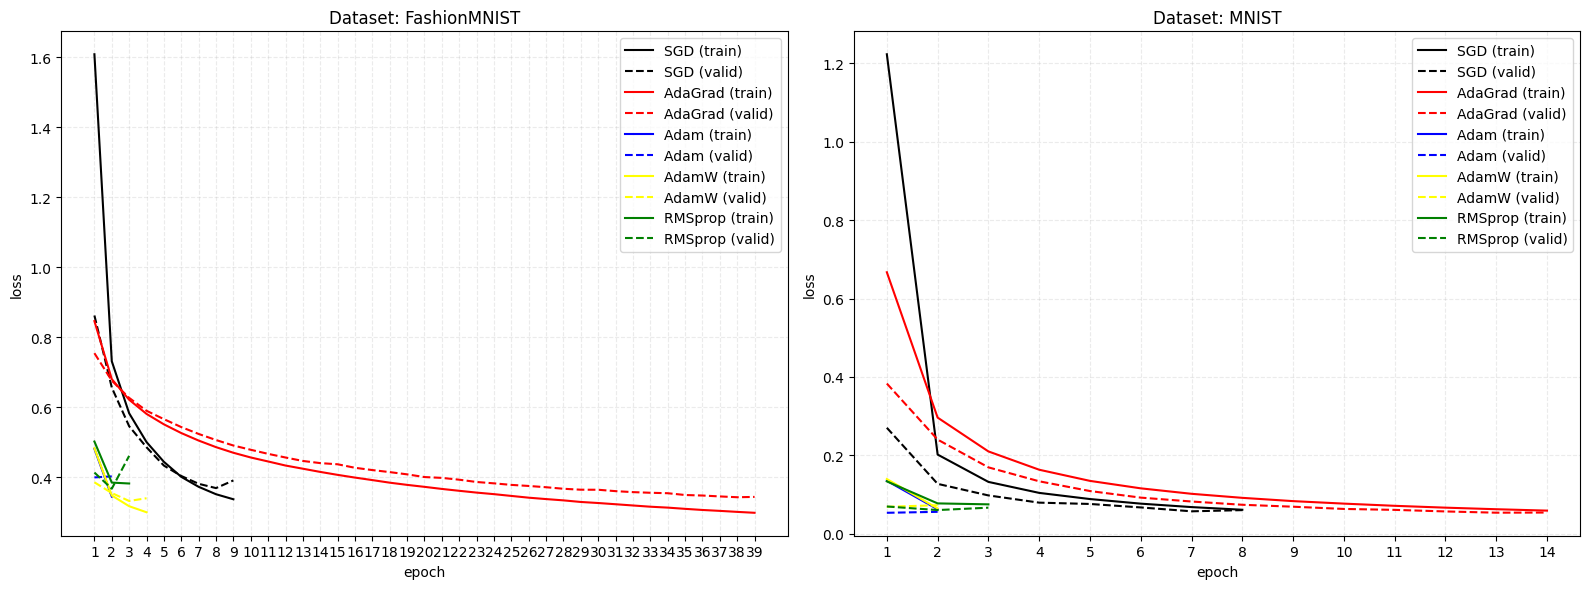

In [11]:
cols = len(datasets)
fig, ax = plt.subplots(nrows=1, ncols=cols, figsize=(8 * cols, 6), tight_layout=True)
colors = ["black", "red", "blue", "yellow", "green"]

for dataset_idx, (dataset_name, dataset) in enumerate(datasets.items()):
    max_epochs = 0
    for optimizer_idx, (optimizer_name, optimizer) in enumerate(optimizers.items()):
        results_df = pd.read_csv(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_results.csv")
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["train_loss"],
            label=f"{optimizer_name} (train)",
            color=colors[optimizer_idx],
        )
        ax[dataset_idx].plot(
            results_df["epoch"] + 1,
            results_df["valid_loss"],
            label=f"{optimizer_name} (valid)",
            color=colors[optimizer_idx],
            linestyle="--",
        )
        if len(results_df["epoch"]) > max_epochs:
            max_epochs = len(results_df["epoch"])

    ax[dataset_idx].set_title(f"Dataset: {dataset_name}")
    ax[dataset_idx].set_xticks(np.arange(1, max_epochs + 1, step=1))
    ax[dataset_idx].set_xlabel("epoch")
    ax[dataset_idx].set_ylabel("loss")
    ax[dataset_idx].grid(linestyle="--", alpha=0.25)
    ax[dataset_idx].legend()

fig.savefig(f"{RESULT_PATH}/plot_loss.png")

In [12]:
def predict(images):
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    return predicted.cpu().numpy()


def get_validation_images_and_labels(valid_loader, num_images=5):
    images, labels = next(iter(valid_loader))
    images = images[:num_images]
    labels = labels[:num_images]
    return images, labels


fashion_mnist_labels = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

DATASET: FashionMNIST


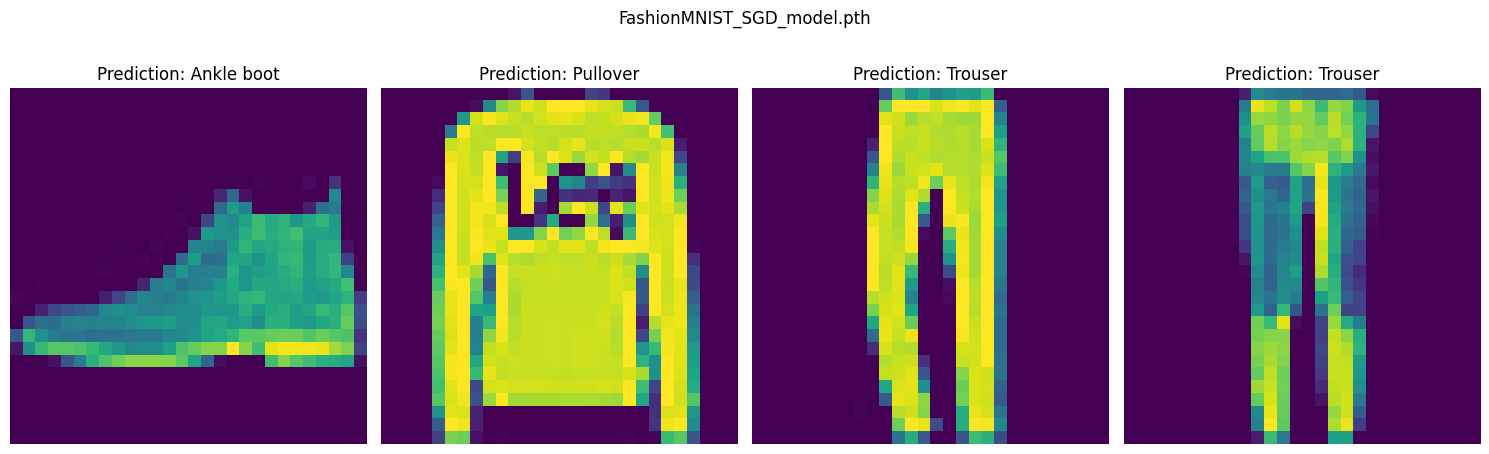

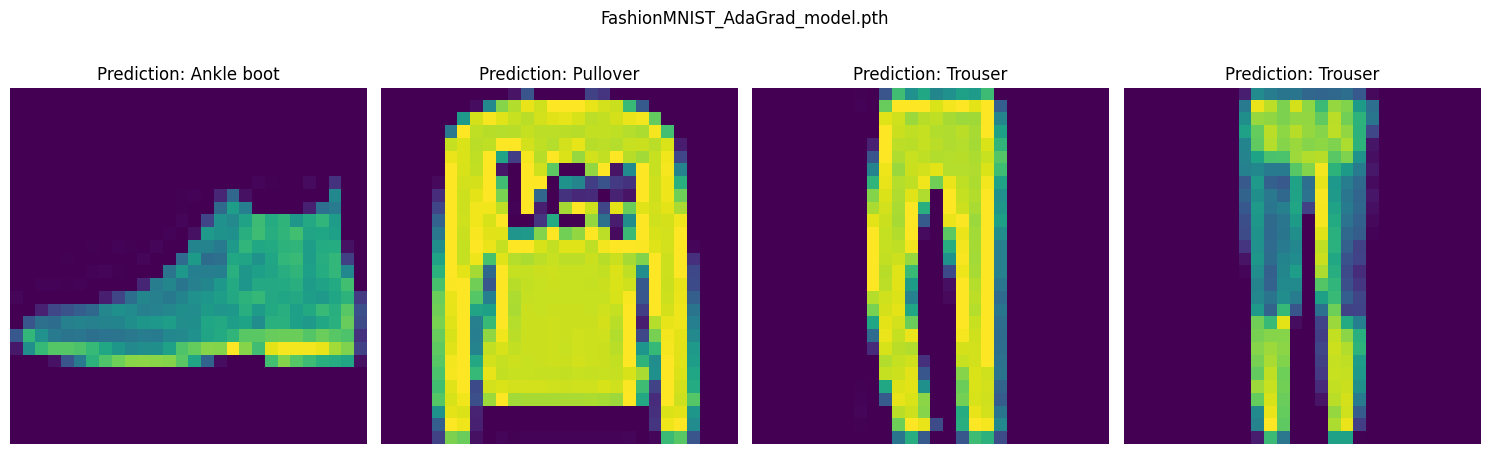

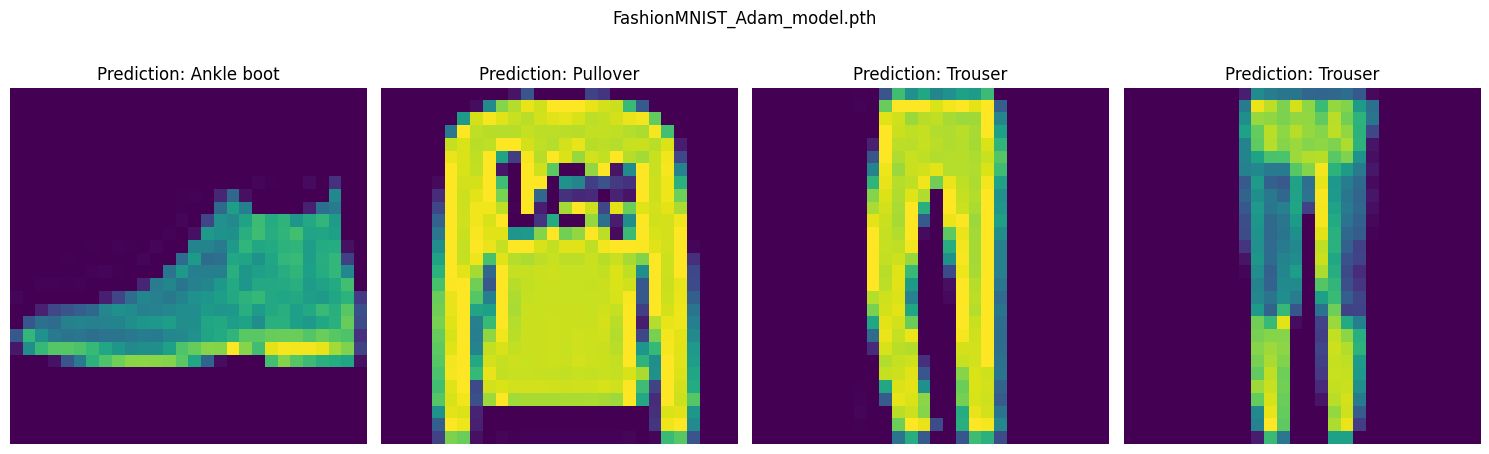

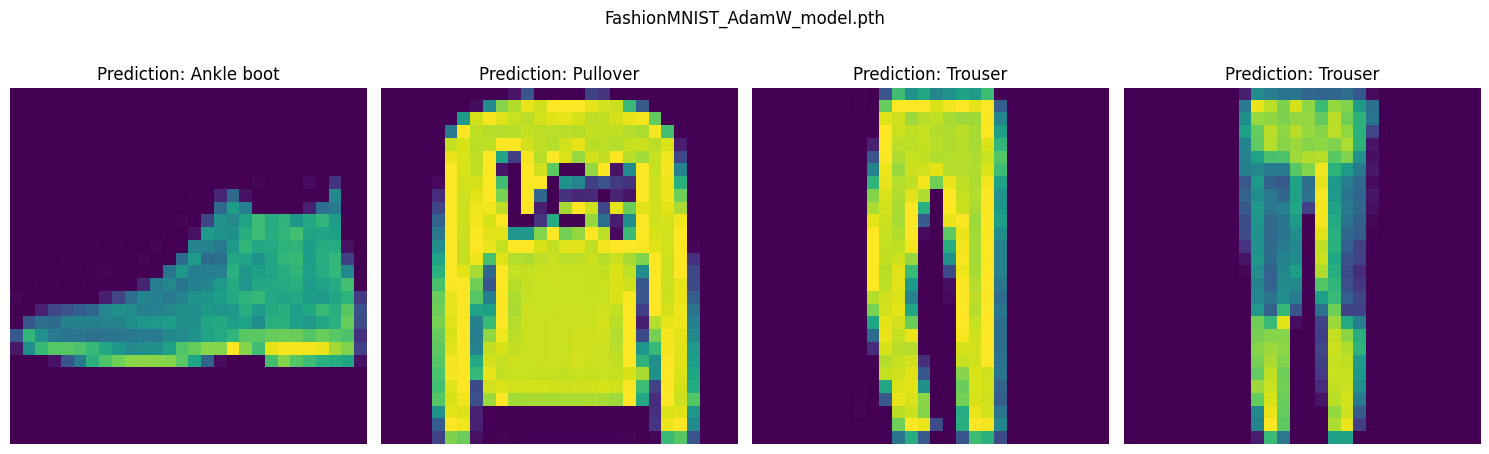

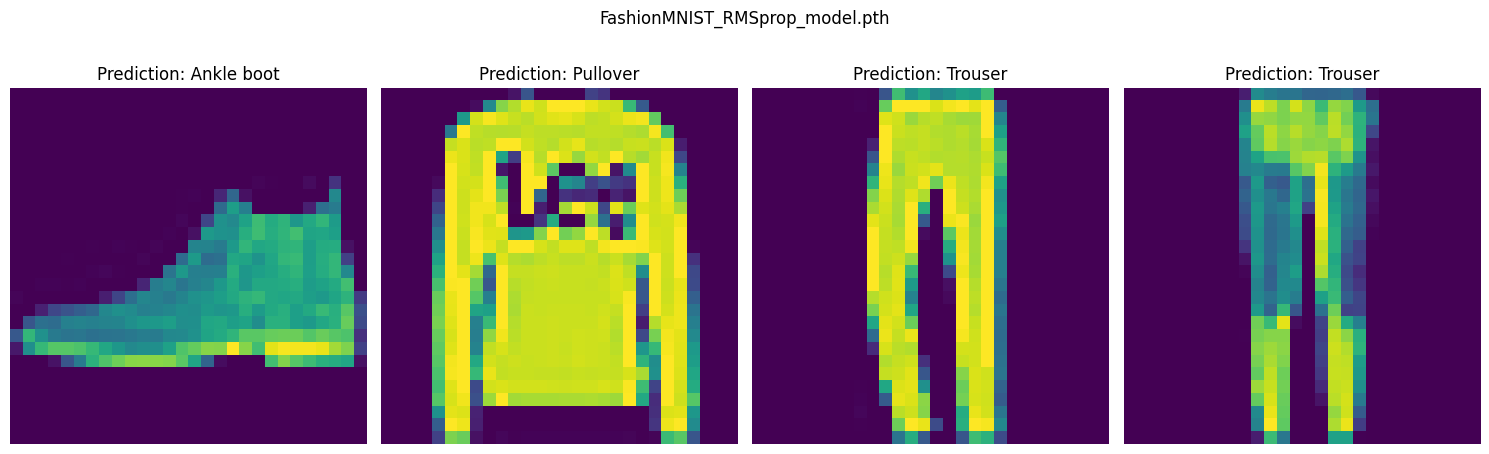

DATASET: MNIST


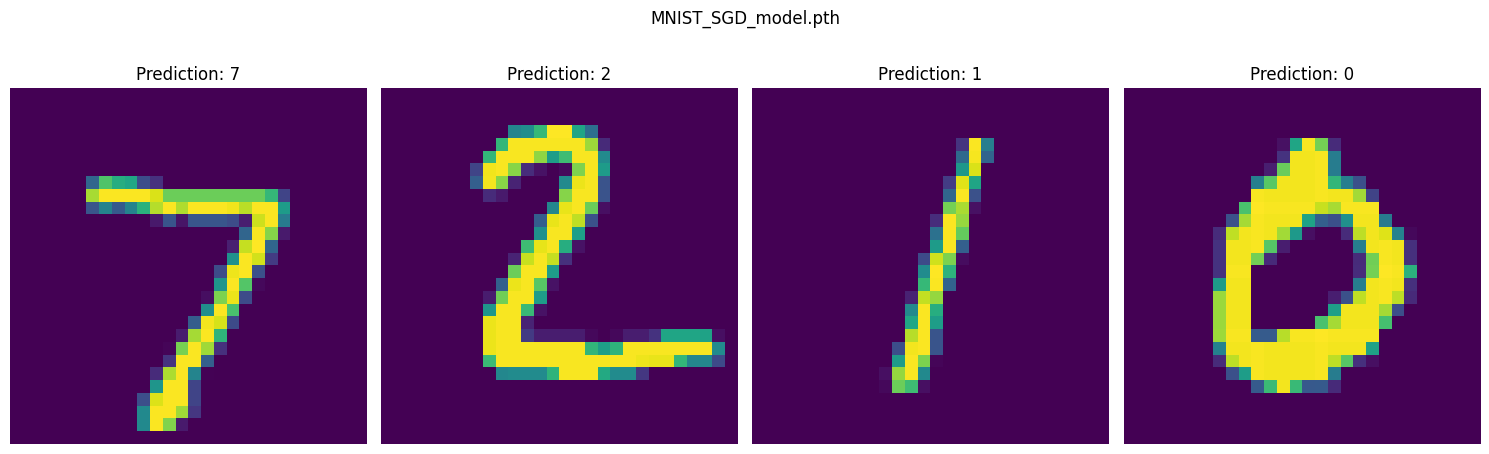

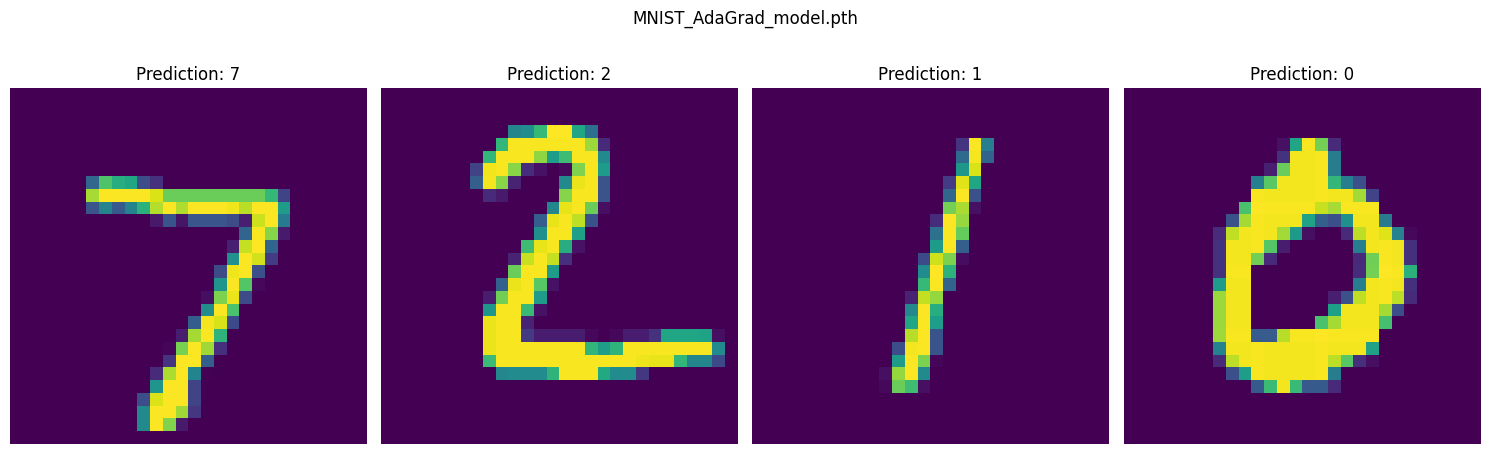

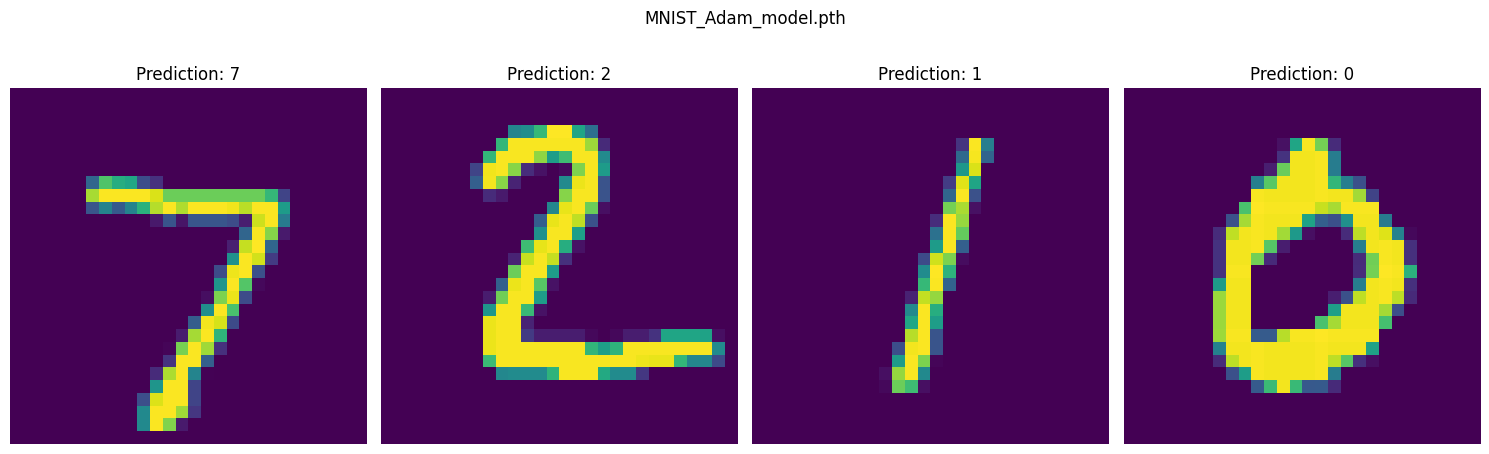

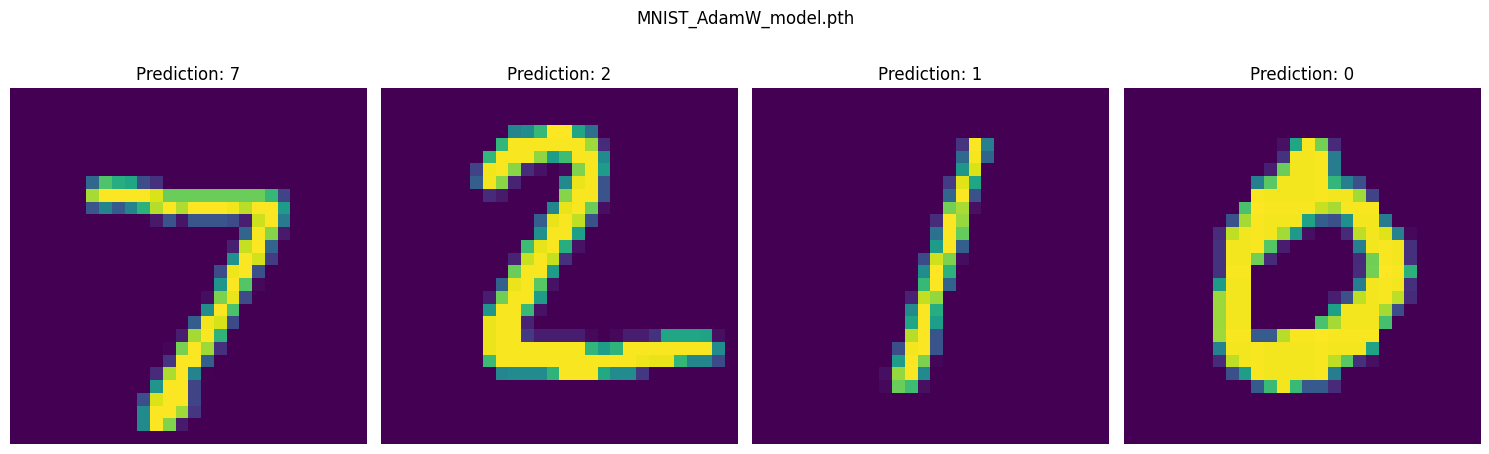

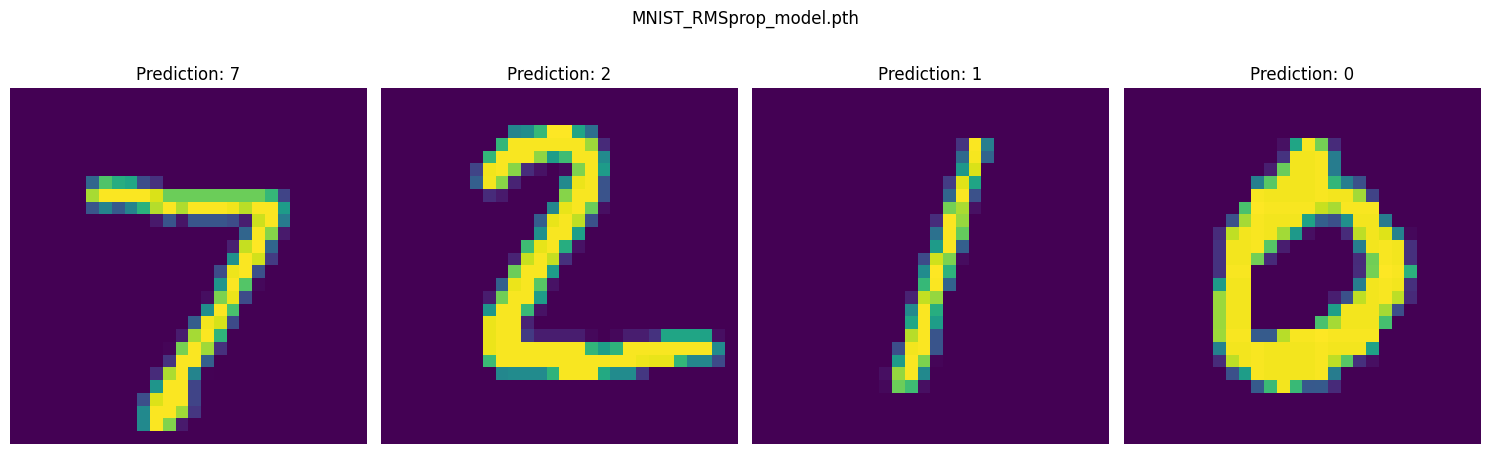

In [13]:
for dataset_name, dataset in datasets.items():
    print(f"DATASET: {dataset_name}")
    train_loader, valid_loader = get_dataset(dataset)

    for optimizer_name in optimizers:
        model = CNNClassifier()
        model.load_state_dict(torch.load(f"{MODEL_PATH}/{dataset_name}_{optimizer_name}_model.pth"))
        model.to(device)
        model.eval()

        images, paths = get_validation_images_and_labels(valid_loader, num_images=5)
        image_predictions = {}

        for i, (image, path) in enumerate(zip(images, paths)):
            prediction = predict(image)
            image_predictions[i] = prediction

        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        if len(images) == 1:
            axes = [axes]

        fig.suptitle(f"{dataset_name}_{optimizer_name}_model.pth")
        for ax, image, i in zip(axes, images, range(len(images))):
            ax.imshow(image[0])
            if "Fashion" in dataset_name:
                ax.set_title(f"Prediction: {fashion_mnist_labels[image_predictions[i][0]]}")
            else:
                ax.set_title(f"Prediction: {image_predictions[i][0]}")
            ax.axis("off")
        plt.tight_layout()
        plt.savefig(f"{RESULT_PATH}/{dataset_name}_{optimizer_name}_model.png")
        plt.show()